In [1]:
!pip install umap-learn
!pip install pytorch-metric-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstallin

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Dataset, random_split
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.linalg import sqrtm
import numpy as np
import os
from PIL import Image
import umap
from pytorch_metric_learning.losses import CircleLoss

2025-04-22 07:56:27.662369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745308587.873383      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745308587.930066      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 44.6MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
def evaluate_accuracy(loader, model):
    total = 0
    correct = 0
    features = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, f = model(images)
            features.append(f.cpu().numpy())
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total , np.concatenate(features)

In [6]:
def fgsm_perturbation(image, epsilon, grad):
    noise = grad.sign()
    perturbed_image = image + epsilon * noise
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, noise

def fgsm_attack(model, loader, epsilon, attack_model):
    model.eval() 
    attack_model.eval()
    features = []  
    total = 0
    correct = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        images.requires_grad = True
        outputs, _ = attack_model(images)
        loss = F.cross_entropy(outputs, labels)
        attack_model.zero_grad()
        loss.backward()
        grad = images.grad

        perturbed_images, noise = fgsm_perturbation(images, epsilon, grad)

        outputs_adv, f = model(perturbed_images)
        features.append(f.detach().cpu().numpy())
        
        _, predicted_adv = torch.max(outputs_adv, 1)
        correct += (predicted_adv == labels).sum().item()
        total += labels.size(0)
        
    accuracy = 100 * correct / total
    return accuracy, np.concatenate(features)
    

def pgd_perturbation(epsilon, alpha, grad, original_image, perturbed_image):
    perturbation = alpha * grad.sign()
    perturbation = torch.clamp(perturbed_image + perturbation - original_image, -epsilon, epsilon)
    perturbed_image = original_image + perturbation
    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    noise = (perturbed_image - original_image)
    
    return perturbed_image, noise

def pgd_attack(model, loader, epsilon, alpha, pgd_iter, attack_model):
    model.eval() 
    attack_model.eval()
    features = []
    total = 0
    correct = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        perturbed_images = images.clone().detach()
        
        for _ in range(pgd_iter):
            perturbed_images.requires_grad = True
            outputs, _ = attack_model(perturbed_images)
            loss = F.cross_entropy(outputs, labels)
            
            attack_model.zero_grad()
            loss.backward()
            grad = perturbed_images.grad.data
            
            with torch.no_grad():
                perturbed_images, noise = pgd_perturbation(epsilon, alpha, grad, images, perturbed_images)
        
        outputs_adv, f = model(perturbed_images)
        features.append(f.detach().cpu().numpy())
        
        _, predicted_adv = torch.max(outputs_adv, 1)
        correct += (predicted_adv == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy, np.concatenate(features)

In [7]:
class ResNetF(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  
        self.classifier = list(base_model.children())[-1]  

    def forward(self, x):
        features = self.feature_extractor(x)  
        features = features.view(features.size(0), -1)  
        preds = self.classifier(features)  
        return preds, features  

In [11]:
transform_a = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    
    transforms.RandomApply([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01),
        transforms.Lambda(lambda x: x + 0.02 * torch.randn_like(x))
    ], p=0.5)
])

trainset_a = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_a)
trainloader_a = torch.utils.data.DataLoader(trainset_a, batch_size=64, shuffle=True)

Files already downloaded and verified


In [12]:
def train_model(model, trainloader, criterion, optimizer, num_epochs):
    model.train()  
    losses = []  
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return losses

In [8]:
def plot_loss(losses):
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Trend Over Time")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
resnet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model = ResNetF(resnet).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = train_model(model, trainloader_a, criterion, optimizer, 20)
plot_loss(losses)

In [9]:
def plot_umap(f_clean, f_fgsm, f_pgd):
    features = np.concatenate([f_clean, f_fgsm, f_pgd], axis=0)
    labels = np.concatenate([np.full(len(f_clean), 'clean'), 
                             np.full(len(f_fgsm), 'FGSM'), 
                             np.full(len(f_pgd), 'PGD')])
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(features)
    
    plt.figure(figsize=(12, 12))
    for label in set(labels):
        idx = labels == label
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=label, alpha=0.4, s = 3)
    plt.legend()
    plt.show()

accuracy on clean data 89.89
accuracy FGSM 67.22
accuracy PGD 35.96


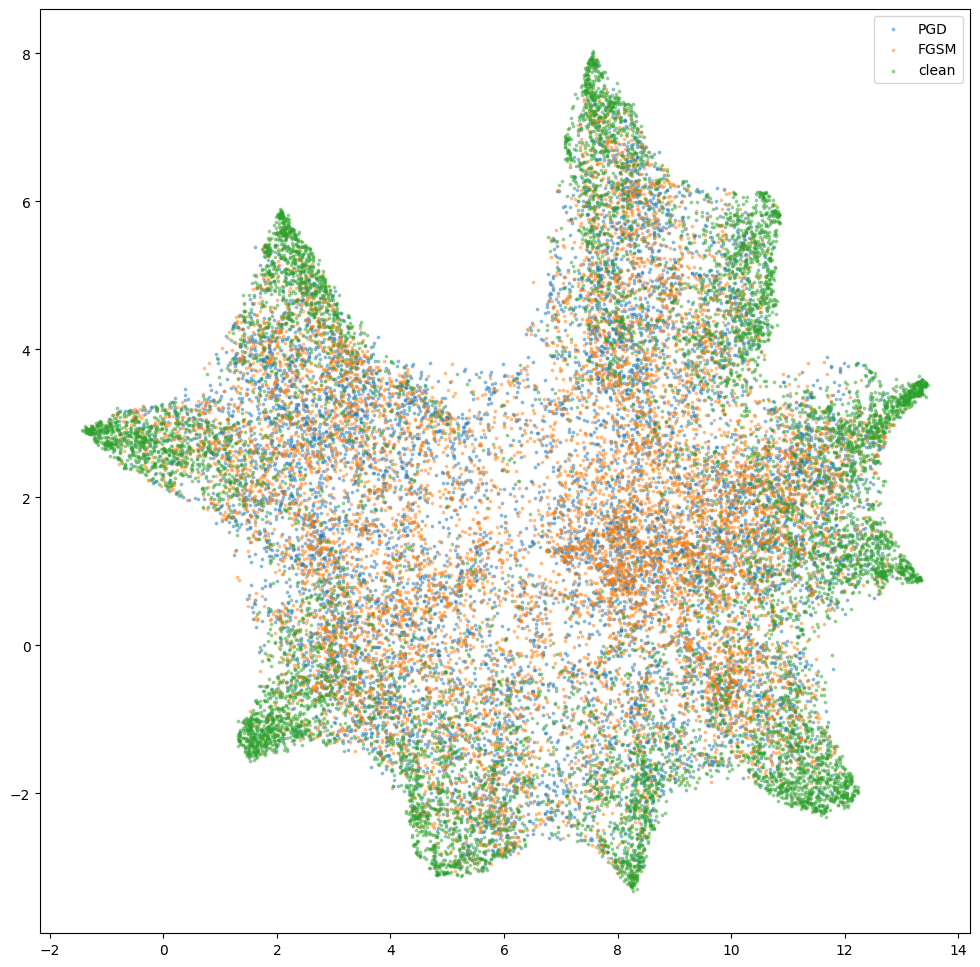

In [27]:
acc, f_c = evaluate_accuracy(testloader, model)
print('accuracy on clean data', acc)

fgsm_acc, f_fgsm = fgsm_attack(model, testloader, 0.03, model)
print('accuracy FGSM', fgsm_acc)

pgd_acc, f_pgd = pgd_attack(model, testloader, 0.03, 0.005, 40, model)
print('accuracy PGD', pgd_acc)

plot_umap(f_c, f_fgsm, f_pgd)

In [10]:
def train_adversarial(model, trainloader, criterion, optimizer, num_epochs, attack_model):
    model.train() 
    attack_model.eval()
    losses = []  
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs_c, inputs_a = inputs.to(device).chunk(2)
            labels_c, labels_a = labels.to(device).chunk(2)

            # obtaining the adverserial example
            inputs_a.requires_grad = True
            attack_model.eval()
            outputs_a, _ = attack_model(inputs_a)
            loss = criterion(outputs_a, labels_a)
            attack_model.zero_grad()
            loss.backward()
            grad = inputs_a.grad
            inputs_a, _ = fgsm_perturbation(inputs_a, 0.03, grad)

            # the model training
            model.train()
            outputs_a, _ = model(inputs_a)
            loss = criterion(outputs_a, labels_a)
            model.zero_grad()
            
            outputs_c, _ = model(inputs_c)
            loss += criterion(outputs_c, labels_c)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return losses

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 39.0MB/s

Epoch [1/20], Loss: 1.3024
Epoch [2/20], Loss: 1.1060
Epoch [3/20], Loss: 1.0476
Epoch [4/20], Loss: 0.9684
Epoch [5/20], Loss: 0.9200
Epoch [6/20], Loss: 0.8726
Epoch [7/20], Loss: 0.8249
Epoch [8/20], Loss: 0.7914
Epoch [9/20], Loss: 0.7327
Epoch [10/20], Loss: 0.6984
Epoch [11/20], Loss: 0.6557
Epoch [12/20], Loss: 0.6360
Epoch [13/20], Loss: 0.5950
Epoch [14/20], Loss: 0.5839
Epoch [15/20], Loss: 0.5535
Epoch [16/20], Loss: 0.5238
Epoch [17/20], Loss: 0.5111
Epoch [18/20], Loss: 0.4747
Epoch [19/20], Loss: 0.4759
Epoch [20/20], Loss: 0.4389


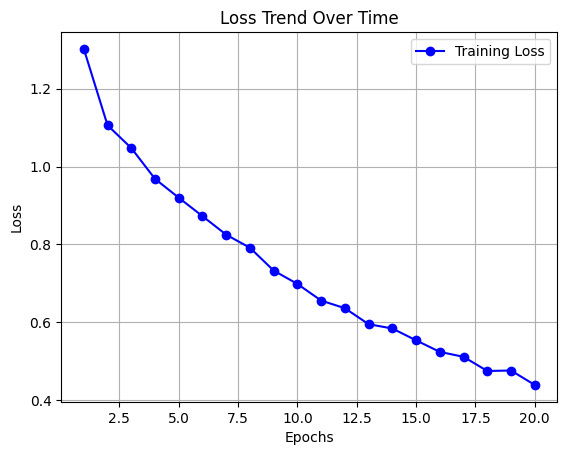

In [11]:
resnet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model = ResNetF(resnet).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
losses = train_adversarial(model, trainloader, criterion, optimizer, 20, model)
plot_loss(losses)

accuracy on clean data 88.14
accuracy FGSM 60.09
accuracy PGD 29.18


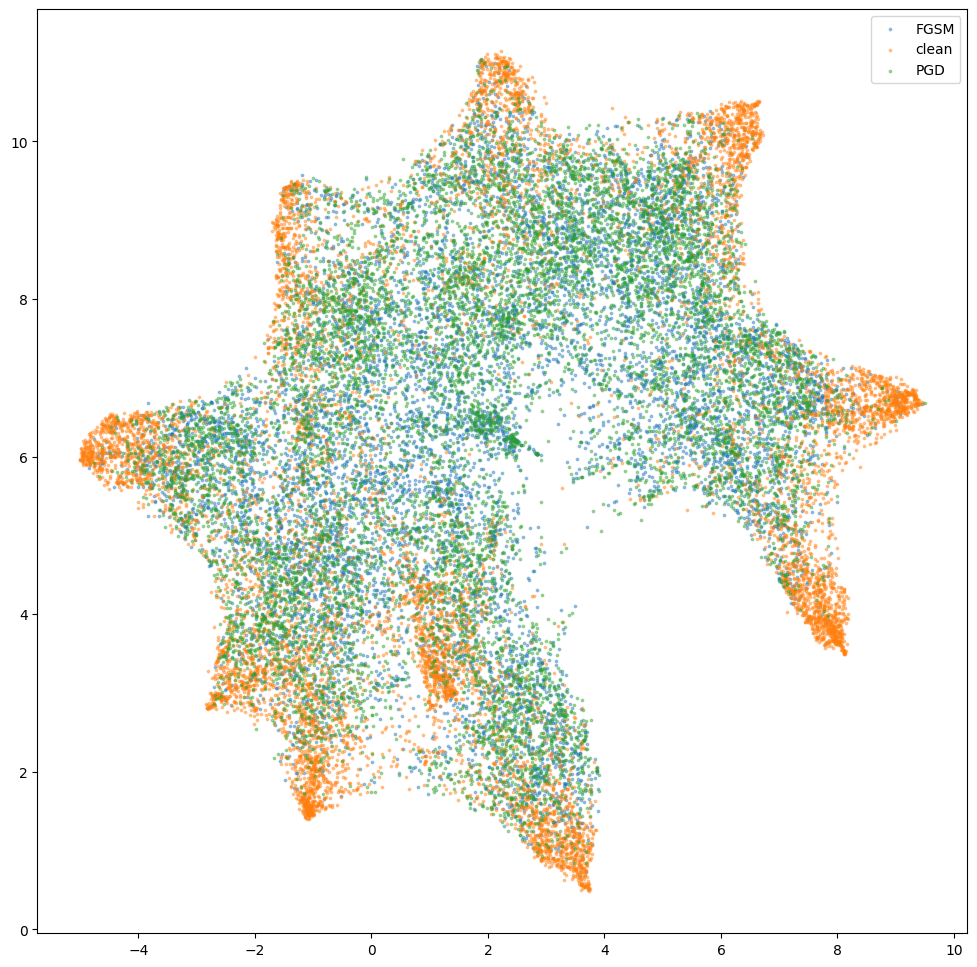

In [12]:
acc, f_c = evaluate_accuracy(testloader, model)
print('accuracy on clean data', acc)

fgsm_acc, f_fgsm = fgsm_attack(model, testloader, 0.03, model)
print('accuracy FGSM', fgsm_acc)

pgd_acc, f_pgd = pgd_attack(model, testloader, 0.03, 0.005, 40, model)
print('accuracy PGD', pgd_acc)

plot_umap(f_c, f_fgsm, f_pgd)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Epoch [1/20], Loss: 1.1727
Epoch [2/20], Loss: 0.9824
Epoch [3/20], Loss: 0.8934
Epoch [4/20], Loss: 0.8447
Epoch [5/20], Loss: 0.7809
Epoch [6/20], Loss: 0.7351
Epoch [7/20], Loss: 0.6981
Epoch [8/20], Loss: 0.6664
Epoch [9/20], Loss: 0.6168
Epoch [10/20], Loss: 0.5827
Epoch [11/20], Loss: 0.5608
Epoch [12/20], Loss: 0.5223
Epoch [13/20], Loss: 0.4879
Epoch [14/20], Loss: 0.4557
Epoch [15/20], Loss: 0.4406
Epoch [16/20], Loss: 0.4294
Epoch [17/20], Loss: 0.4090
Epoch [18/20], Loss: 0.3759
Epoch [19/20], Loss: 0.3635
Epoch [20/20], Loss: 0.3679


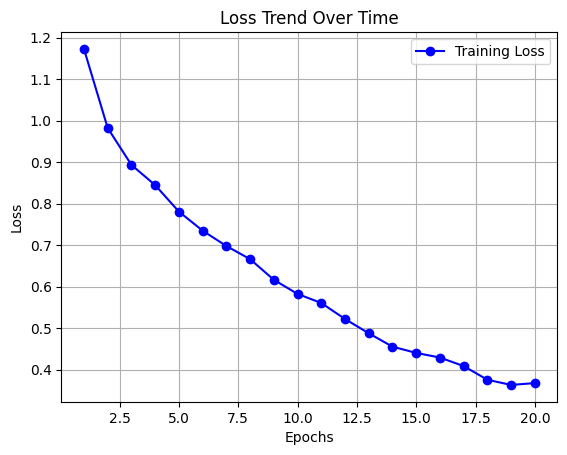

In [13]:
resnet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model = ResNetF(resnet).to(device)

resnet2 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model_a = ResNetF(resnet2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
losses = train_adversarial(model, trainloader, criterion, optimizer, 20, model_a)
plot_loss(losses)

accuracy on clean data 88.19
accuracy FGSM 61.89
accuracy PGD 24.37


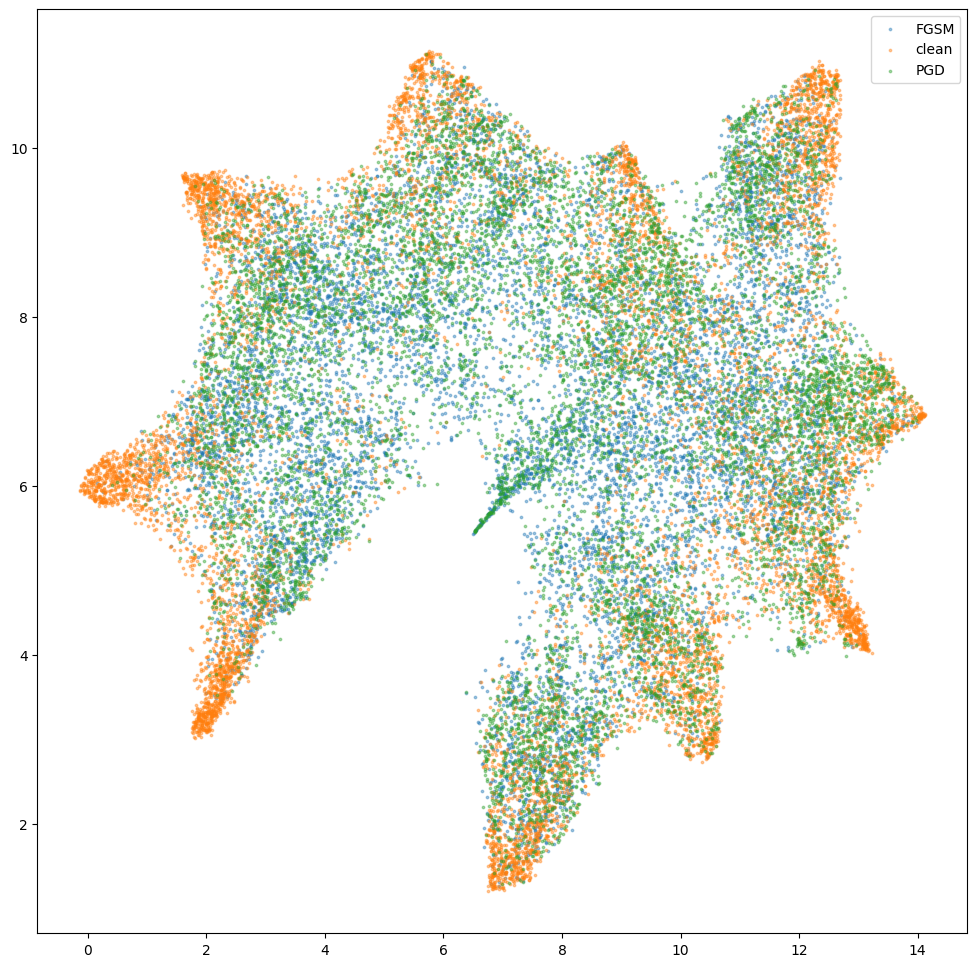

In [14]:
acc, f_c = evaluate_accuracy(testloader, model)
print('accuracy on clean data', acc)

fgsm_acc, f_fgsm = fgsm_attack(model, testloader, 0.03, model)
print('accuracy FGSM', fgsm_acc)

pgd_acc, f_pgd = pgd_attack(model, testloader, 0.03, 0.005, 40, model)
print('accuracy PGD', pgd_acc)

plot_umap(f_c, f_fgsm, f_pgd)

In [15]:
def train_circle(model, trainloader, optimizer, circle_loss, num_epochs):
    model.train()
    
    losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            _, features = model(inputs)
            
            loss = circle_loss(features, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    return losses

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Epoch [1/20], Loss: 63.7075
Epoch [2/20], Loss: 49.2899
Epoch [3/20], Loss: 40.2083
Epoch [4/20], Loss: 36.0278
Epoch [5/20], Loss: 32.3989
Epoch [6/20], Loss: 29.6480
Epoch [7/20], Loss: 27.5133
Epoch [8/20], Loss: 26.6612
Epoch [9/20], Loss: 24.2580
Epoch [10/20], Loss: 23.3423
Epoch [11/20], Loss: 22.5559
Epoch [12/20], Loss: 21.1362
Epoch [13/20], Loss: 19.6640
Epoch [14/20], Loss: 19.6652
Epoch [15/20], Loss: 19.0218
Epoch [16/20], Loss: 17.6879
Epoch [17/20], Loss: 18.0518
Epoch [18/20], Loss: 16.0617
Epoch [19/20], Loss: 17.7973
Epoch [20/20], Loss: 16.1619


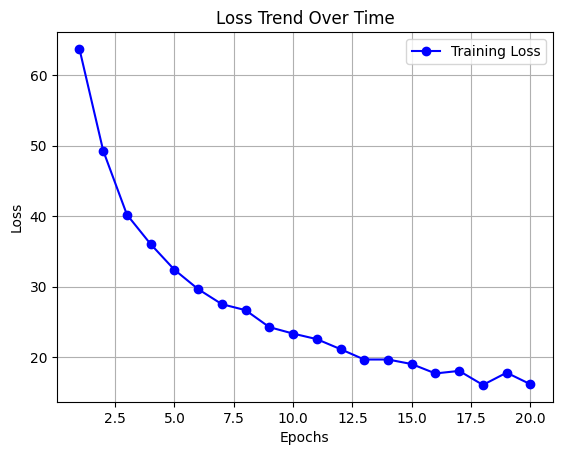

In [16]:
resnet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model = ResNetF(resnet).to(device)

circle_loss = CircleLoss(m=0.5, gamma=512)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
losses = train_circle(model, trainloader, optimizer, circle_loss, 20)
plot_loss(losses)

accuracy on clean data 88.62
accuracy FGSM 36.5
accuracy PGD 7.97


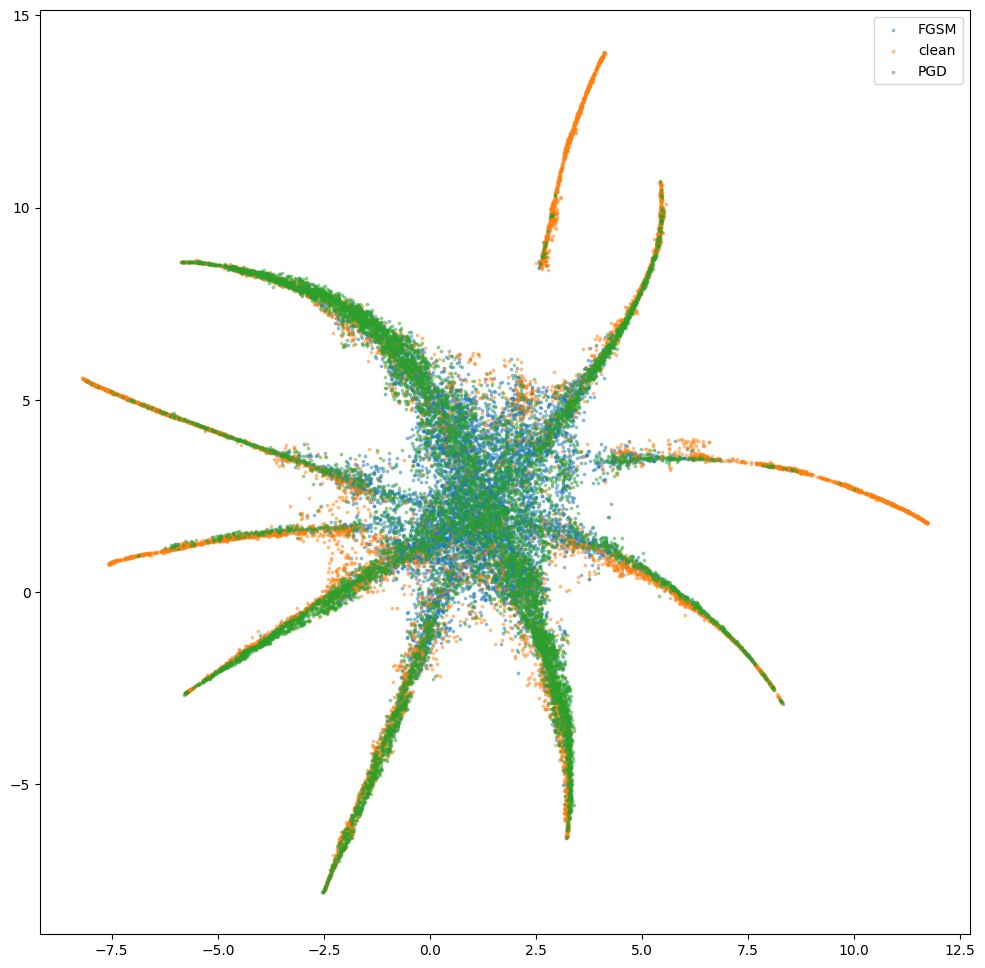

In [17]:
acc, f_c = evaluate_accuracy(testloader, model)
print('accuracy on clean data', acc)

fgsm_acc, f_fgsm = fgsm_attack(model, testloader, 0.03, model)
print('accuracy FGSM', fgsm_acc)

pgd_acc, f_pgd = pgd_attack(model, testloader, 0.03, 0.005, 40, model)
print('accuracy PGD', pgd_acc)

plot_umap(f_c, f_fgsm, f_pgd)

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # [B, 32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # [B, 64, 8, 8]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),# [B, 128, 4, 4]
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # [B, 64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [B, 32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),   # [B, 3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

In [19]:
def train_ae(model, trainloader, criterion, optimizer, num_epochs, attack_model):
    model.train() 
    attack_model.eval()
    losses = []  
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs_c, inputs_a = inputs.to(device).chunk(2)
            inputs_a_clean = inputs_a.clone().detach()
            labels_c, labels_a = labels.to(device).chunk(2)
            # obtaining the adverserial example
            inputs_a.requires_grad = True
            attack_model.eval()
            outputs_a, _ = attack_model(inputs_a)
            loss = F.cross_entropy(outputs_a, labels_a)
            attack_model.zero_grad()
            loss.backward()
            grad = inputs_a.grad
            inputs_a, _ = fgsm_perturbation(inputs_a, 0.03, grad)

            # the model training
            model.train()
            outputs_a = model(inputs_a)
            loss = criterion(outputs_a, inputs_a_clean)
            model.zero_grad()
            
            outputs_c = model(inputs_c)
            loss += criterion(outputs_c, inputs_c)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return losses

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Epoch [1/40], Loss: 2.0553
Epoch [2/40], Loss: 1.8882
Epoch [3/40], Loss: 1.8645
Epoch [4/40], Loss: 1.8564
Epoch [5/40], Loss: 1.8499
Epoch [6/40], Loss: 1.8440
Epoch [7/40], Loss: 1.8407
Epoch [8/40], Loss: 1.8388
Epoch [9/40], Loss: 1.8365
Epoch [10/40], Loss: 1.8354
Epoch [11/40], Loss: 1.8344
Epoch [12/40], Loss: 1.8328
Epoch [13/40], Loss: 1.8327
Epoch [14/40], Loss: 1.8315
Epoch [15/40], Loss: 1.8311
Epoch [16/40], Loss: 1.8301
Epoch [17/40], Loss: 1.8295
Epoch [18/40], Loss: 1.8285
Epoch [19/40], Loss: 1.8283
Epoch [20/40], Loss: 1.8279
Epoch [21/40], Loss: 1.8274
Epoch [22/40], Loss: 1.8268
Epoch [23/40], Loss: 1.8269
Epoch [24/40], Loss: 1.8264
Epoch [25/40], Loss: 1.8262
Epoch [26/40], Loss: 1.8258
Epoch [27/40], Loss: 1.8254
Epoch [28/40], Loss: 1.8254
Epoch [29/40], Loss: 1.8253
Epoch [30/40], Loss: 1.8248
Epoch [31/40], Loss: 1.8243
Epoch [32/40], Loss: 1.8241
Epoch [33/40], Loss: 1.8240
Epoch [34/40], Loss: 1.8242
Epoch [35/40], Loss: 1.8240
Epoch [36/40], Loss: 1.8236
E

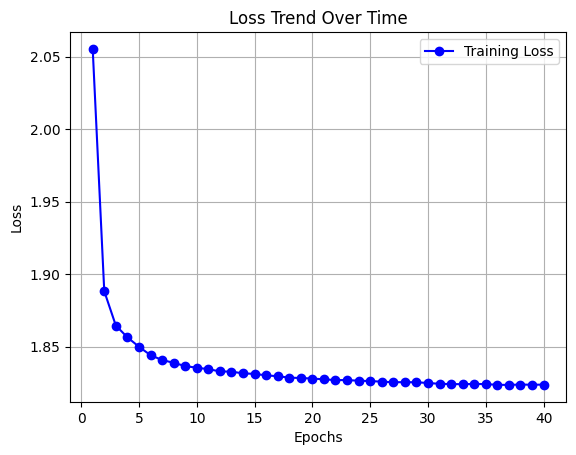

In [23]:
ae = Autoencoder().to(device)

resnet2 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model_a = ResNetF(resnet2).to(device)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.001)
losses = train_ae(ae, trainloader, mse_loss, optimizer, 40, model_a)
plot_loss(losses)

In [21]:
class ResNetVAE(nn.Module):
    def __init__(self, resnet, vae):
        super().__init__()
        self.resnet = resnet 
        self.vae = vae

    def forward(self, x):
        return self.resnet(self.vae(x)) 

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


accuracy on clean data 55.74
accuracy FGSM 53.29
accuracy PGD 36.31


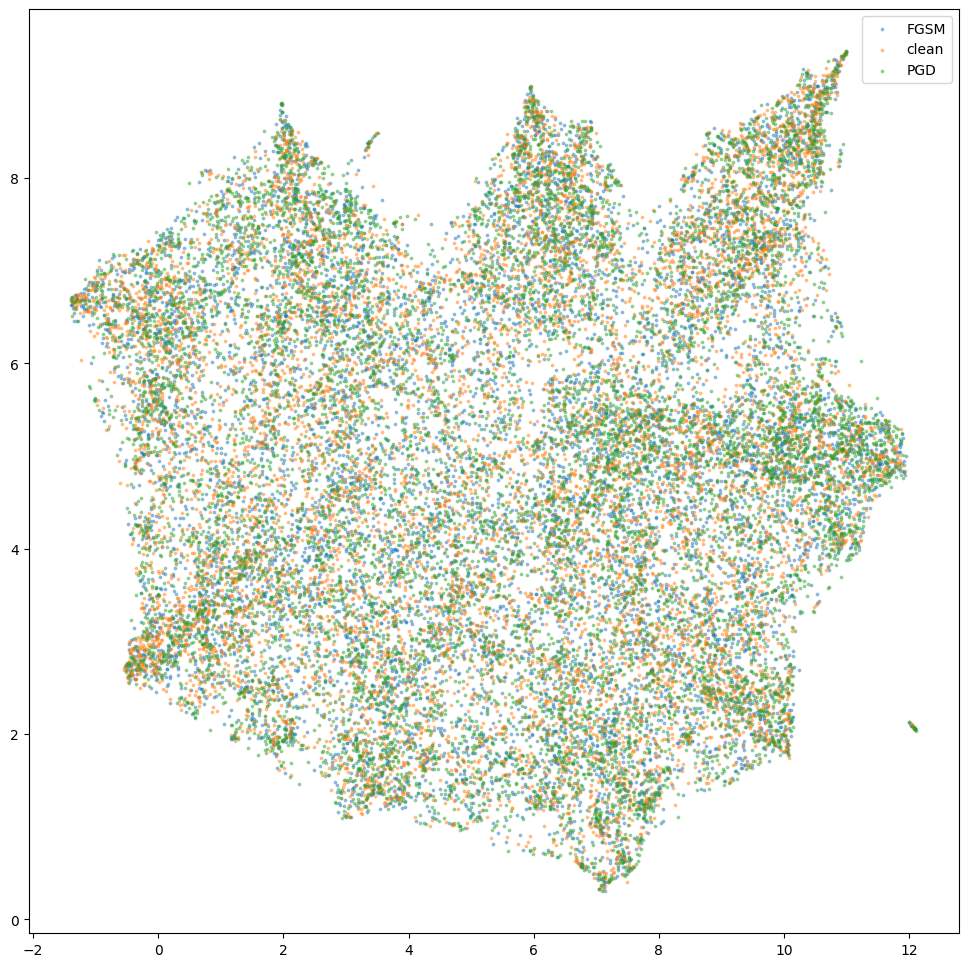

In [24]:
resnet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
resnet = ResNetF(resnet).to(device)
model = ResNetVAE(resnet, ae)

acc, f_c = evaluate_accuracy(testloader, model)
print('accuracy on clean data', acc)

fgsm_acc, f_fgsm = fgsm_attack(model, testloader, 0.03, resnet)
print('accuracy FGSM', fgsm_acc)

pgd_acc, f_pgd = pgd_attack(model, testloader, 0.03, 0.005, 40, resnet)
print('accuracy PGD', pgd_acc)

plot_umap(f_c, f_fgsm, f_pgd)